In [761]:
import jax.numpy as jnp
import numpy as np
from jax import grad, jacfwd, jacrev, hessian
from jax import jit
import matplotlib.pyplot as plt

### Generate points based on desired polynomial with some error

In [762]:
GlobalSeed = 3

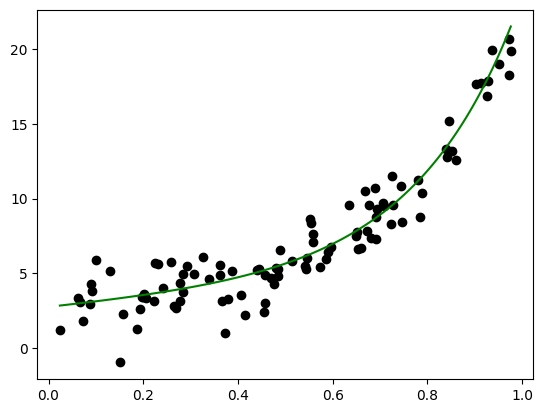

In [763]:
#set the random_seed
np.random.seed(GlobalSeed)

def function(params,x):
    return params[0] + params[1] * x + params[2] * x ** 2 + params[3] * x ** 3 + params[4] * x ** 4 + params[5] * x ** 5 + params[6] * x ** 6 + params[7] * x ** 7 + params[8] * x ** 8 + params[9] * x ** 9 + params[10] * x ** 10

def generate_points(params,n, error):
    X = np.random.rand(n)
    Y = function(params,X) + error*np.random.randn(n)
    return X, Y

params = np.random.rand(11)*5
X, Y = generate_points(params,100, 1.5)
#plot the function as well
X_org = jnp.linspace(min(X), max(X), 100)
Y_org = function(params,X_org)
plt.plot(X_org, Y_org, color='green', label='Function')
plt.scatter(X, Y,color = 'black')

## Polynomial regression using Newton's method

In [764]:
def predict(params, X):
    #third polynomial
    return params[0] + params[1] * X + params[2] * X ** 2 + params[3] * X ** 3

# Define the loss function (mean squared error)
def loss(params, X, Y):
    predictions = predict(params, X)
    return jnp.mean((predictions - Y) ** 2)

grad_loss = jit(grad(loss))
hessian_loss = hessian(loss)

# Newton's method for polynomial regression
def newton_method(X, Y, num_iterations=10):
    params = np.zeros(3)
    for i in range(num_iterations):
        grad_l = grad_loss(params, X, Y)
        hess_l = hessian_loss(params, X, Y)
        print(hess_l)
        
        #Add the damping factor to the hessian matrix to ensure that we are heading to teh minimum point.
        while jnp.any(jnp.linalg.eigvals(hess_l) <= 0):
            hess_l += 0.1 * jnp.eye(len(params))
        if jnp.linalg.cond(hess_l) < 1 / jnp.finfo(hess_l.dtype).eps:
            print(jnp.linalg.inv(hess_l))
            params_new = params - jnp.linalg.solve(hess_l, grad_l)
        else:
            print("Hessian is not invertible.")
            break
        params = params_new

        print(f"Iteration {i+1}, Parameters: {params}",)

    return params

def showNewton(X, Y):
    params = newton_method(X, Y)
    print("Final parameters:", params)

    #get the array of error for each X value
    error = Y - predict(params, X)

    # Plot the original data and the fitted curve
    plt.scatter(X, Y, color='black', label='Data points')
    X_fit = jnp.linspace(min(X), max(X), 100)
    Y_fit = predict(params, X_fit)
    plt.plot(X_fit, Y_fit, color='blue', label='Fitted curve')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.legend()
    plt.show()
    return X_fit,Y_fit,error

### Add outliers to the data

In [765]:
def AddOutliers(X, Y, severity_factor=10):
    #set the random_seed
    np.random.seed(GlobalSeed)
    # Calculate the standard deviation of the original data
    std_dev = np.std(Y)
    # Add outliers
    X_outliers = np.random.rand(5)

    # Add outlier which is between 1 and 3 std of the original data
    Y_outliers = function(params, X_outliers) + np.random.uniform(-severity_factor * std_dev, severity_factor * std_dev, len(X_outliers))
    X_ol = np.concatenate((X, X_outliers))
    Y_ol = np.concatenate((Y, Y_outliers))
    return X_ol, Y_ol

In [766]:
def GaussianCalc(X):
    ave = jnp.mean(X)
    std = jnp.std(X)
    return 1/(std*jnp.sqrt(2*jnp.pi))*jnp.exp(-0.5*((X-ave)/std)**2)

In [767]:
def GaussianCurve(error):
    X_axis = jnp.linspace(-1.5*jnp.max(jnp.abs(error)), 1.5*jnp.max(jnp.abs(error)), 100)
    #Gaussian curve
    Y_axis = GaussianCalc(X_axis)
    #Plot the error distribution
    plt.plot(X_axis, Y_axis)
    #plot the vertical line for each one of the actual error value
    for i in range(len(error)):
        plt.axvline(error[i], color='red')
    
    std = jnp.std(error)
    #plot the axvline for the outlier threshold
    plt.axvline(2*std, color='green')
    plt.axvline(-2*std, color='green')

In [768]:
#remove outlier based on the gaussian curve
def removeOutliers(X, Y, error,threshold=2):
    ave = jnp.mean(error)
    std = jnp.std(error)
    X_new = []
    Y_new = []
    counter = 0
    for i in range(len(error)):
        if error[i] < threshold*std and error[i] > -threshold*std:
            counter+=1
            X_new.append(X[i])
            Y_new.append(Y[i])
    print(f"Number of outliers removed: {len(error)-counter}")
    return jnp.array(X_new), jnp.array(Y_new)

In [769]:
#Create the weighted loss function
def weighted_loss(params, X, Y, error):
    #for each point multiply the error by the corresponding y value of the gaussian curve
    weighted_error = jnp.abs(error*GaussianCalc(error) ** 20)
    predictions = predict(params, X)
    return jnp.mean((predictions - Y) ** 2 * weighted_error)

In [770]:
# Compute the gradient and Hessian of the loss function
grad_weighted_loss = jit(grad(weighted_loss))
hessian_weighted_loss = hessian(weighted_loss)

# Newton's method for polynomial regression
def newton_method_weighted(X, Y,error, num_iterations=10, tol=1e-6,reg=1e-4):
    #random initialization of the parameters using random function from np
    params = np.zeros(3)
    for i in range(num_iterations):
        grad_weighted_l = grad_weighted_loss(params, X, Y,error)
        hess_weighted_l = hessian_weighted_loss(params, X, Y,error)
        print(hess_weighted_l)
        # Check if the Hessian is invertible
        while jnp.any(jnp.linalg.eigvals(hess_weighted_l) <= 0):
            hess_weighted_l += reg * jnp.eye(len(params))
        if jnp.linalg.cond(hess_weighted_l) < 1 / jnp.finfo(hess_weighted_l.dtype).eps:
            print(jnp.linalg.inv(hess_weighted_l))
            params_new = params - jnp.linalg.solve(hess_weighted_l, grad_weighted_l)
        else:
            print("Hessian is not invertible.")
            break
        params = params_new

        print(f"Iteration {i+1}, Parameters: {params}",)

    return params

def showNewton_weighted(X, Y,error):
    params = newton_method_weighted(X, Y,error)
    print("Final parameters:", params)

    #get the array of error for each X value
    error = Y - predict(params, X)

    plt.ylim(0, 15)

    # Plot the original data and the fitted curve
    plt.scatter(X, Y, color='black', label='Data points')
    X_fit = jnp.linspace(min(X), max(X), 100)
    Y_fit = predict(params, X_fit)
    plt.plot(X_fit, Y_fit, color='blue', label='Fitted curve')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.legend()
    plt.show()
    return X_fit,Y_fit,error

In [771]:
class PlotConfig:
    def __init__(self, X, Y, label,color):
        self.x = X
        self.y = Y
        self.label = label
        self.color = color

In [772]:
from sklearn.metrics import mean_squared_error
def plot_and_calculate_rmse(plot_config1, plot_config2, title):
    plt.figure(figsize=(10, 6))
    plt.plot(plot_config1.x, plot_config1.y, color=plot_config1.color, label=plot_config1.label)
    plt.plot(plot_config2.x, plot_config2.y, color=plot_config2.color, label=plot_config2.label)
    plt.scatter(X,Y, color='black', label='Data points')
    plt.legend()
    plt.title(title)
    plt.show()
    rmse = np.sqrt(mean_squared_error(plot_config1.y, plot_config2.y))
    return rmse

[[1.9999999  1.0015633  1.0895938 ]
 [1.0015633  0.6355655  0.8022504 ]
 [0.6355655  0.4540284  0.62839496]]
[[  5.9086595 -22.643288   18.662704 ]
 [-20.0916     94.8772    -86.289024 ]
 [  8.540516  -45.649075   45.061302 ]]
Iteration 1, Parameters: [ 3.8397603 -5.2205253 10.957552 ]
[[1.9999999  1.0015633  1.0895938 ]
 [1.0015633  0.6355655  0.8022504 ]
 [0.6355655  0.4540284  0.62839496]]
[[  5.9086595 -22.643288   18.662704 ]
 [-20.0916     94.8772    -86.289024 ]
 [  8.540516  -45.649075   45.061302 ]]
Iteration 2, Parameters: [ 3.8397346 -5.2204185 10.9574995]
[[1.9999999  1.0015633  1.0895938 ]
 [1.0015633  0.6355655  0.8022504 ]
 [0.6355655  0.4540284  0.62839496]]
[[  5.9086595 -22.643288   18.662704 ]
 [-20.0916     94.8772    -86.289024 ]
 [  8.540516  -45.649075   45.061302 ]]
Iteration 3, Parameters: [ 3.8397348 -5.2204194 10.9575   ]
[[1.9999999  1.0015633  1.0895938 ]
 [1.0015633  0.6355655  0.8022504 ]
 [0.6355655  0.4540284  0.62839496]]
[[  5.9086595 -22.643288   18.

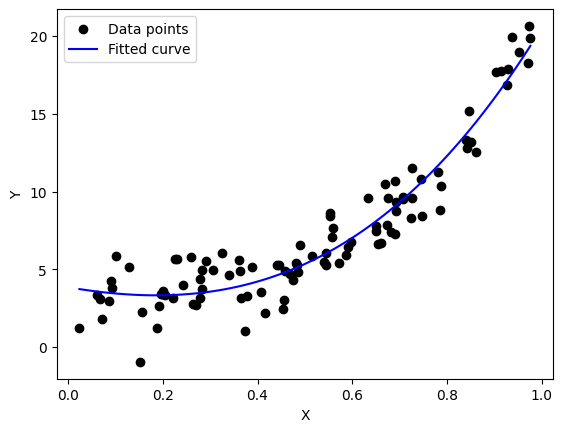

In [773]:
X_init_fit,Y_init_fit,error_init_fit = showNewton(X,Y)

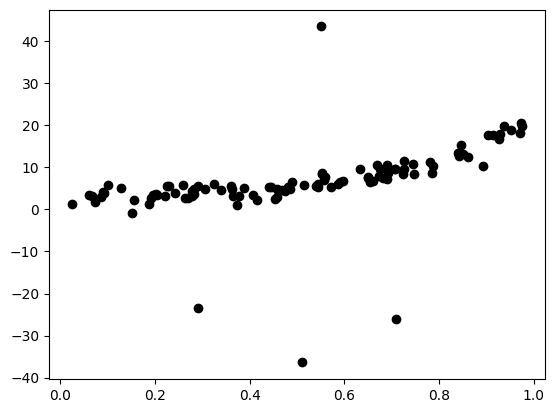

In [774]:
X_ol = AddOutliers(X,Y,10)[0]
Y_ol = AddOutliers(X,Y,10)[1]
plt.scatter(X_ol, Y_ol, color='black', label='Data points')

[[2.         1.0101292  1.1013256 ]
 [1.0101292  0.642401   0.8106512 ]
 [0.642401   0.4589247  0.63443136]]
[[  6.1228805 -23.338036   19.191551 ]
 [-20.695023   96.73685   -87.68148  ]
 [  8.770237  -46.344734   45.569195 ]]
Iteration 1, Parameters: [ 3.8002477 -7.810831  12.15249  ]
[[2.         1.0101292  1.1013256 ]
 [1.0101292  0.642401   0.8106512 ]
 [0.642401   0.4589247  0.63443136]]
[[  6.1228805 -23.338036   19.191551 ]
 [-20.695023   96.73685   -87.68148  ]
 [  8.770237  -46.344734   45.569195 ]]
Iteration 2, Parameters: [ 3.8002653 -7.8109083 12.152527 ]
[[2.         1.0101292  1.1013256 ]
 [1.0101292  0.642401   0.8106512 ]
 [0.642401   0.4589247  0.63443136]]
[[  6.1228805 -23.338036   19.191551 ]
 [-20.695023   96.73685   -87.68148  ]
 [  8.770237  -46.344734   45.569195 ]]
Iteration 3, Parameters: [ 3.8002648 -7.8109064 12.152526 ]
[[2.         1.0101292  1.1013256 ]
 [1.0101292  0.642401   0.8106512 ]
 [0.642401   0.4589247  0.63443136]]
[[  6.1228805 -23.338036   19.

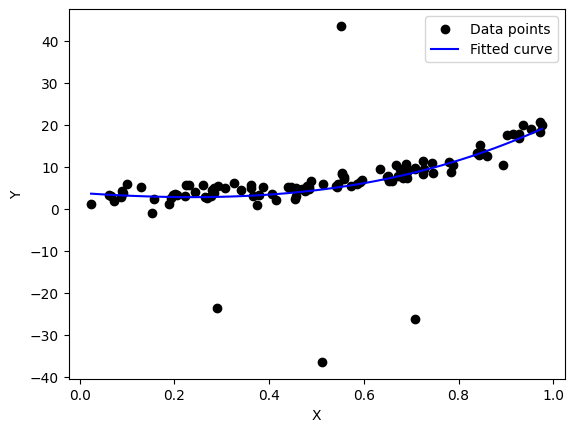

In [775]:
X_ol_fit,Y_ol_fit,error_ol_fit = showNewton(X_ol,Y_ol)

Number of outliers removed: 4
[[1.9999996  1.0093288  1.1086938 ]
 [1.0093288  0.6450619  0.8209957 ]
 [0.6450619  0.46363196 0.6460047 ]]
[[  5.958297 -22.79468   18.74352 ]
 [-20.223406  95.27694  -86.37768 ]
 [  8.564562 -45.61802   44.824318]]
Iteration 1, Parameters: [ 3.782421 -4.80085  10.584788]
[[1.9999996  1.0093288  1.1086938 ]
 [1.0093288  0.6450619  0.8209957 ]
 [0.6450619  0.46363196 0.6460047 ]]
[[  5.958297 -22.79468   18.74352 ]
 [-20.223406  95.27694  -86.37768 ]
 [  8.564562 -45.61802   44.824318]]
Iteration 2, Parameters: [ 3.7824268 -4.80088   10.584805 ]
[[1.9999996  1.0093288  1.1086938 ]
 [1.0093288  0.6450619  0.8209957 ]
 [0.6450619  0.46363196 0.6460047 ]]
[[  5.958297 -22.79468   18.74352 ]
 [-20.223406  95.27694  -86.37768 ]
 [  8.564562 -45.61802   44.824318]]
Iteration 3, Parameters: [ 3.7824268 -4.80088   10.584805 ]
[[1.9999996  1.0093288  1.1086938 ]
 [1.0093288  0.6450619  0.8209957 ]
 [0.6450619  0.46363196 0.6460047 ]]
[[  5.958297 -22.79468   18.74

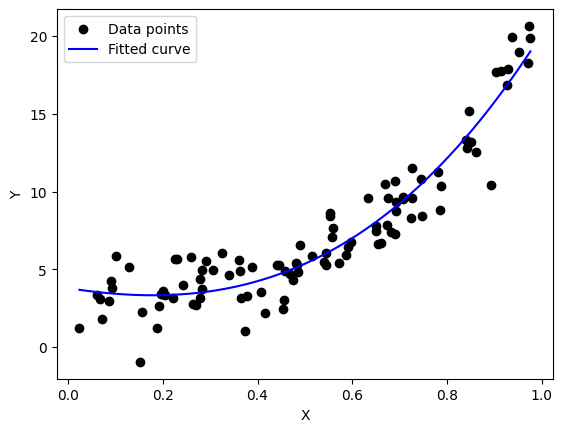

Number of outliers removed: 4
[[1.9999996  1.0093288  1.1086938 ]
 [1.0093288  0.6450619  0.8209957 ]
 [0.6450619  0.46363196 0.6460047 ]]
[[  5.958297 -22.79468   18.74352 ]
 [-20.223406  95.27694  -86.37768 ]
 [  8.564562 -45.61802   44.824318]]
Iteration 1, Parameters: [ 3.782421 -4.80085  10.584788]
[[1.9999996  1.0093288  1.1086938 ]
 [1.0093288  0.6450619  0.8209957 ]
 [0.6450619  0.46363196 0.6460047 ]]
[[  5.958297 -22.79468   18.74352 ]
 [-20.223406  95.27694  -86.37768 ]
 [  8.564562 -45.61802   44.824318]]
Iteration 2, Parameters: [ 3.7824268 -4.80088   10.584805 ]
[[1.9999996  1.0093288  1.1086938 ]
 [1.0093288  0.6450619  0.8209957 ]
 [0.6450619  0.46363196 0.6460047 ]]
[[  5.958297 -22.79468   18.74352 ]
 [-20.223406  95.27694  -86.37768 ]
 [  8.564562 -45.61802   44.824318]]
Iteration 3, Parameters: [ 3.7824268 -4.80088   10.584805 ]
[[1.9999996  1.0093288  1.1086938 ]
 [1.0093288  0.6450619  0.8209957 ]
 [0.6450619  0.46363196 0.6460047 ]]
[[  5.958297 -22.79468   18.74

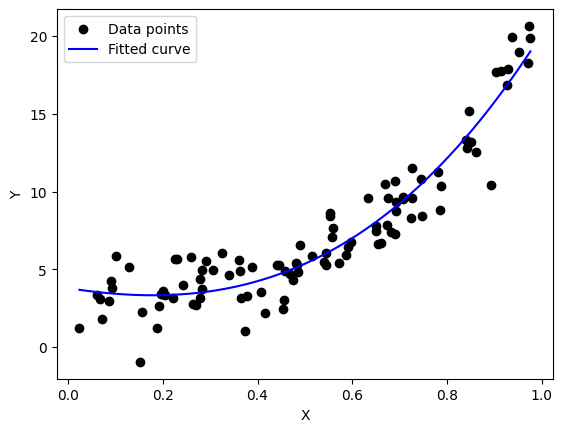

Number of outliers removed: 4
[[1.9999996  1.0093288  1.1086938 ]
 [1.0093288  0.6450619  0.8209957 ]
 [0.6450619  0.46363196 0.6460047 ]]
[[  5.958297 -22.79468   18.74352 ]
 [-20.223406  95.27694  -86.37768 ]
 [  8.564562 -45.61802   44.824318]]
Iteration 1, Parameters: [ 3.782421 -4.80085  10.584788]
[[1.9999996  1.0093288  1.1086938 ]
 [1.0093288  0.6450619  0.8209957 ]
 [0.6450619  0.46363196 0.6460047 ]]
[[  5.958297 -22.79468   18.74352 ]
 [-20.223406  95.27694  -86.37768 ]
 [  8.564562 -45.61802   44.824318]]
Iteration 2, Parameters: [ 3.7824268 -4.80088   10.584805 ]
[[1.9999996  1.0093288  1.1086938 ]
 [1.0093288  0.6450619  0.8209957 ]
 [0.6450619  0.46363196 0.6460047 ]]
[[  5.958297 -22.79468   18.74352 ]
 [-20.223406  95.27694  -86.37768 ]
 [  8.564562 -45.61802   44.824318]]
Iteration 3, Parameters: [ 3.7824268 -4.80088   10.584805 ]
[[1.9999996  1.0093288  1.1086938 ]
 [1.0093288  0.6450619  0.8209957 ]
 [0.6450619  0.46363196 0.6460047 ]]
[[  5.958297 -22.79468   18.74

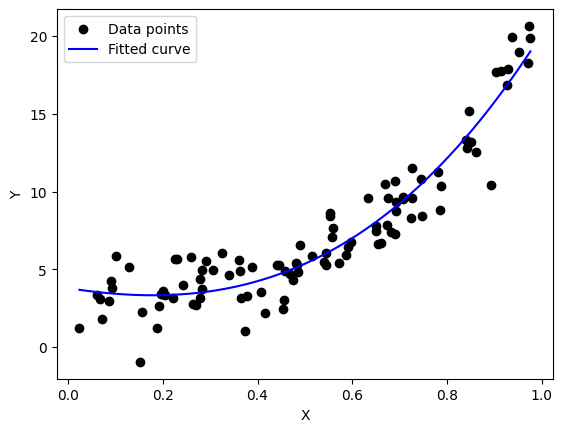

In [776]:
X_new2, Y_new2 = removeOutliers(X_ol, Y_ol, error_ol_fit,2)
X_ol_removed_fit2,Y_ol_removed_fit2,error_ol_removed_fit2 = showNewton(X_new2,Y_new2)
X_new1, Y_new1 = removeOutliers(X_ol, Y_ol, error_ol_fit,1)
X_ol_removed_fit1,Y_ol_removed_fit1,error_ol_removed_fit1 = showNewton(X_new1,Y_new1)
X_new3, Y_new3 = removeOutliers(X_ol, Y_ol, error_ol_fit,3)
X_ol_removed_fit3,Y_ol_removed_fit3,error_ol_removed_fit3 = showNewton(X_new3,Y_new3)

[[1.1054088e-25 5.7003336e-26 6.3458387e-26]
 [5.7003336e-26 3.6803492e-26 4.7353308e-26]
 [3.6803498e-26 2.6654889e-26 3.7540972e-26]]
[[ 1.1625283e+26 -4.3651054e+26  3.5409311e+26]
 [-3.8658875e+26  1.7658819e+27 -1.5739615e+27]
 [ 1.6051713e+26 -8.2587815e+26  7.9704655e+26]]
Iteration 1, Parameters: [ 4.0735745 -5.633112  11.124699 ]
[[1.1054088e-25 5.7003336e-26 6.3458387e-26]
 [5.7003336e-26 3.6803492e-26 4.7353308e-26]
 [3.6803498e-26 2.6654889e-26 3.7540972e-26]]
[[ 1.1625283e+26 -4.3651054e+26  3.5409311e+26]
 [-3.8658875e+26  1.7658819e+27 -1.5739615e+27]
 [ 1.6051713e+26 -8.2587815e+26  7.9704655e+26]]
Iteration 2, Parameters: [ 4.0735817 -5.6331086 11.12472  ]
[[1.1054088e-25 5.7003336e-26 6.3458387e-26]
 [5.7003336e-26 3.6803492e-26 4.7353308e-26]
 [3.6803498e-26 2.6654889e-26 3.7540972e-26]]
[[ 1.1625283e+26 -4.3651054e+26  3.5409311e+26]
 [-3.8658875e+26  1.7658819e+27 -1.5739615e+27]
 [ 1.6051713e+26 -8.2587815e+26  7.9704655e+26]]
Iteration 3, Parameters: [ 4.0735817 

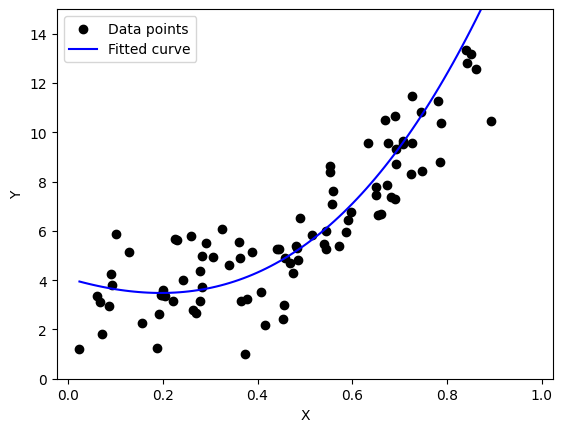

In [777]:
X_weighted_fit,Y_weighted_fit,error_ol_weighted_fit = showNewton_weighted(X_ol,Y_ol,error_ol_fit)

In [778]:
original = PlotConfig(X_org, Y_org, 'Original function', 'green')
init_fit = PlotConfig(X_init_fit, Y_init_fit, 'Fitted curve without outliers', 'blue')
ol_fit = PlotConfig(X_ol_fit, Y_ol_fit, 'Fitted curve with outliers', 'red')
ol_removed_fit2 = PlotConfig(X_ol_removed_fit2, Y_ol_removed_fit2, 'Fitted curve with outliers removed', 'orange')
ol_removed_fit1 = PlotConfig(X_ol_removed_fit1, Y_ol_removed_fit1, 'Fitted curve with outliers removed1', 'purple')
ol_removed_fit3 = PlotConfig(X_ol_removed_fit3, Y_ol_removed_fit3, 'Fitted curve with outliers removed2', 'pink')
weighted_fit = PlotConfig(X_weighted_fit, Y_weighted_fit, 'Fitted curve with weighted loss', 'yellow')

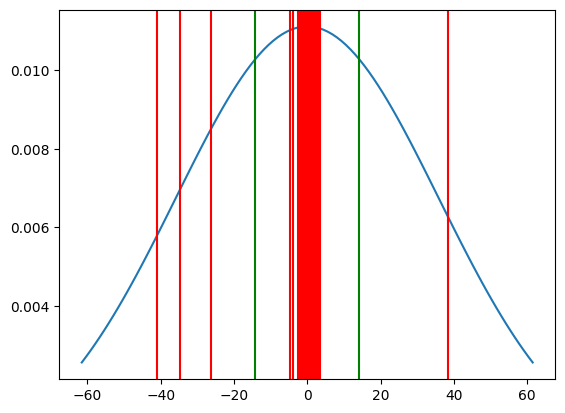

In [779]:
GaussianCurve(error_ol_fit)

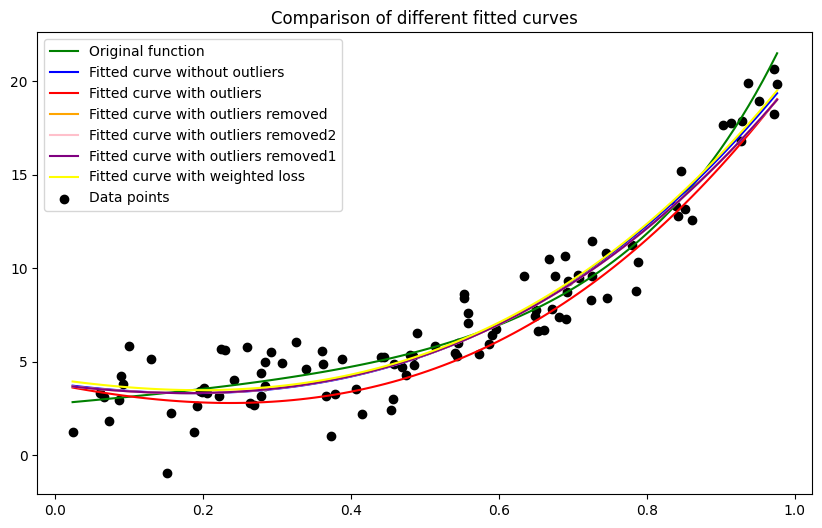

In [780]:
#cast every function on one plot without using the function made
plt.figure(figsize=(10, 6))
plt.plot(original.x, original.y, color=original.color, label=original.label)
plt.plot(init_fit.x, init_fit.y, color=init_fit.color, label=init_fit.label)
plt.plot(ol_fit.x, ol_fit.y, color=ol_fit.color, label=ol_fit.label)
plt.plot(ol_removed_fit2.x, ol_removed_fit2.y, color=ol_removed_fit2.color, label=ol_removed_fit2.label)
plt.plot(ol_removed_fit3.x, ol_removed_fit3.y, color=ol_removed_fit3.color, label=ol_removed_fit3.label)
plt.plot(ol_removed_fit1.x, ol_removed_fit1.y, color=ol_removed_fit1.color, label=ol_removed_fit1.label)
plt.plot(weighted_fit.x, weighted_fit.y, color=weighted_fit.color, label=weighted_fit.label)
plt.scatter(X,Y, color='black', label='Data points')
plt.legend()
plt.title('Comparison of different fitted curves')
plt.show()

In [781]:
# Function to calculate RMSE
def calculate_rmse(y_true, y_pred):
    return jnp.mean((y_true - y_pred) ** 2)

# Generate a common set of X values for comparison
X_comp = jnp.linspace(min(X), max(X), 100)

# Compute RMSE for each fitted curve
rmse_init = float(calculate_rmse(Y_org, Y_init_fit))
rmse_ol = float(calculate_rmse(Y_org, Y_ol_fit))
rmse_ol_removed2 = float(calculate_rmse(Y_org, Y_ol_removed_fit2))
rmse_ol_removed1 = float(calculate_rmse(Y_org, Y_ol_removed_fit1))
rmse_ol_removed3 = float(calculate_rmse(Y_org, Y_ol_removed_fit3))
rmse_ol_weighted = float(calculate_rmse(Y_org, Y_weighted_fit))

# Print RMSE values
#print(f"RMSE without outliers: {rmse_init}")
#print(f"RMSE with outliers: {rmse_ol}")
print(f"RMSE with outliers removed1: {rmse_ol_removed1}")
print(f"RMSE with outliers removed2: {rmse_ol_removed2}")
print(f"RMSE with outliers removed3: {rmse_ol_removed3}")
#print(f"RMSE with weighted loss outliers: {rmse_ol_weighted}")

#use pandas and put it in table
import pandas as pd

# Data dictionary
data = {'Root Mean Square Error': [rmse_ol, rmse_ol_removed1, rmse_ol_removed2, rmse_ol_removed3, rmse_ol_weighted]}

# Create DataFrame
df = pd.DataFrame(data, index=[
    'With Outliers',
    'Outliers Removed 1',
    'Outliers Removed 2',
    'Outliers Removed 3',
    'Weighted Loss'
])

# Display DataFrame
df

RMSE with outliers removed1: 0.34372439980506897
RMSE with outliers removed2: 0.34372439980506897
RMSE with outliers removed3: 0.34372439980506897


,Root Mean Square Error
With Outliers,0.934427
Outliers Removed 1,0.343724
Outliers Removed 2,0.343724
Outliers Removed 3,0.343724
Weighted Loss,0.282207
